### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

- Hint_1: 學員可以善用課程中以搭建好的function模組
- Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import preprocess, convert_one_hot, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [2]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):
    contexts = corpus[window_size:-window_size]
    targets = []
    for idx in range(window_size, len(corpus) - window_size):
        ts = list(corpus[idx - window_size:idx]) + list(corpus[idx + 1:idx + 1 + window_size])
        targets.append(ts)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets = create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([2, 3, 4, 5, 1, 0]),
 array([[6, 3],
        [2, 4],
        [3, 5],
        [4, 1],
        [5, 0],
        [1, 7]]))

In [3]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0]], dtype=int32),
 array([[[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]]], dtype=int32))

In [4]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size * 2)]

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size * 2)])
        
        return loss

    def backward(self, dout=1):
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size * 2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [5]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(len(word2idx), hidden_size, window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 21%|██▏       | 213/1000 [00:00<00:00, 1099.20it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.158683133063523
Epoch: 2, Iteration: 1/2, Loss: 4.158829884418726
Epoch: 3, Iteration: 1/2, Loss: 4.158748943819637
Epoch: 4, Iteration: 1/2, Loss: 4.158641924971452
Epoch: 5, Iteration: 1/2, Loss: 4.158664161763337
Epoch: 6, Iteration: 1/2, Loss: 4.158550190295049
Epoch: 7, Iteration: 1/2, Loss: 4.158653925113125
Epoch: 8, Iteration: 1/2, Loss: 4.1583778876679816
Epoch: 9, Iteration: 1/2, Loss: 4.158492072712999
Epoch: 10, Iteration: 1/2, Loss: 4.158305888374532
Epoch: 11, Iteration: 1/2, Loss: 4.158463987745089
Epoch: 12, Iteration: 1/2, Loss: 4.158133139385151
Epoch: 13, Iteration: 1/2, Loss: 4.1583276629360455
Epoch: 14, Iteration: 1/2, Loss: 4.158143325648012
Epoch: 15, Iteration: 1/2, Loss: 4.157813325742446
Epoch: 16, Iteration: 1/2, Loss: 4.1581137870812075
Epoch: 17, Iteration: 1/2, Loss: 4.157837101411868
Epoch: 18, Iteration: 1/2, Loss: 4.1577483853316135
Epoch: 19, Iteration: 1/2, Loss: 4.157744076896938
Epoch: 20, Iteration: 1/2, Loss: 4.1

 32%|███▏      | 323/1000 [00:00<00:00, 1067.35it/s]

Epoch: 215, Iteration: 1/2, Loss: 1.4524233683135352
Epoch: 216, Iteration: 1/2, Loss: 1.4519207250460615
Epoch: 217, Iteration: 1/2, Loss: 1.441949404600586
Epoch: 218, Iteration: 1/2, Loss: 1.4531522568520894
Epoch: 219, Iteration: 1/2, Loss: 1.4383727021815642
Epoch: 220, Iteration: 1/2, Loss: 1.4449056022402842
Epoch: 221, Iteration: 1/2, Loss: 1.4443441443360252
Epoch: 222, Iteration: 1/2, Loss: 1.4378818497101744
Epoch: 223, Iteration: 1/2, Loss: 1.4480104261943931
Epoch: 224, Iteration: 1/2, Loss: 1.4370317777921708
Epoch: 225, Iteration: 1/2, Loss: 1.4480640644900609
Epoch: 226, Iteration: 1/2, Loss: 1.4444938592194214
Epoch: 227, Iteration: 1/2, Loss: 1.434365772555874
Epoch: 228, Iteration: 1/2, Loss: 1.4445886788232514
Epoch: 229, Iteration: 1/2, Loss: 1.4352546533994301
Epoch: 230, Iteration: 1/2, Loss: 1.4339379119628042
Epoch: 231, Iteration: 1/2, Loss: 1.4466415093976528
Epoch: 232, Iteration: 1/2, Loss: 1.437663311753476
Epoch: 233, Iteration: 1/2, Loss: 1.4314274712277

 56%|█████▌    | 561/1000 [00:00<00:00, 1078.96it/s]

Epoch: 444, Iteration: 1/2, Loss: 1.3984976058716674
Epoch: 445, Iteration: 1/2, Loss: 1.3992059197101017
Epoch: 446, Iteration: 1/2, Loss: 1.400018187083923
Epoch: 447, Iteration: 1/2, Loss: 1.399018188124533
Epoch: 448, Iteration: 1/2, Loss: 1.398398533440506
Epoch: 449, Iteration: 1/2, Loss: 1.3980904432509575
Epoch: 450, Iteration: 1/2, Loss: 1.399636203802979
Epoch: 451, Iteration: 1/2, Loss: 1.3989152833745537
Epoch: 452, Iteration: 1/2, Loss: 1.3981129199847806
Epoch: 453, Iteration: 1/2, Loss: 1.398835556229071
Epoch: 454, Iteration: 1/2, Loss: 1.4003960378658171
Epoch: 455, Iteration: 1/2, Loss: 1.3979774183857367
Epoch: 456, Iteration: 1/2, Loss: 1.3978113347670664
Epoch: 457, Iteration: 1/2, Loss: 1.3986211554224783
Epoch: 458, Iteration: 1/2, Loss: 1.3985894090241828
Epoch: 459, Iteration: 1/2, Loss: 1.3993439903435831
Epoch: 460, Iteration: 1/2, Loss: 1.3984070715080945
Epoch: 461, Iteration: 1/2, Loss: 1.3993999589238069
Epoch: 462, Iteration: 1/2, Loss: 1.398311499947671

 78%|███████▊  | 775/1000 [00:00<00:00, 969.20it/s] 

Epoch: 632, Iteration: 1/2, Loss: 1.3935886784766858
Epoch: 633, Iteration: 1/2, Loss: 1.3936381880284914
Epoch: 634, Iteration: 1/2, Loss: 1.3934442739601334
Epoch: 635, Iteration: 1/2, Loss: 1.3934842180747846
Epoch: 636, Iteration: 1/2, Loss: 1.3936034647857787
Epoch: 637, Iteration: 1/2, Loss: 1.3933723474509283
Epoch: 638, Iteration: 1/2, Loss: 1.3930976303136153
Epoch: 639, Iteration: 1/2, Loss: 1.393840554104112
Epoch: 640, Iteration: 1/2, Loss: 1.3930272059690718
Epoch: 641, Iteration: 1/2, Loss: 1.3938202747847677
Epoch: 642, Iteration: 1/2, Loss: 1.3929879060986474
Epoch: 643, Iteration: 1/2, Loss: 1.3942586736697433
Epoch: 644, Iteration: 1/2, Loss: 1.3929516846484442
Epoch: 645, Iteration: 1/2, Loss: 1.3928739948772844
Epoch: 646, Iteration: 1/2, Loss: 1.393722811096235
Epoch: 647, Iteration: 1/2, Loss: 1.3933445830899718
Epoch: 648, Iteration: 1/2, Loss: 1.3936860287876707
Epoch: 649, Iteration: 1/2, Loss: 1.3928503695976566
Epoch: 650, Iteration: 1/2, Loss: 1.393277496104

100%|██████████| 1000/1000 [00:00<00:00, 1001.71it/s]

Epoch: 827, Iteration: 1/2, Loss: 1.3912016247771941
Epoch: 828, Iteration: 1/2, Loss: 1.3911700215782288
Epoch: 829, Iteration: 1/2, Loss: 1.3911377066389874
Epoch: 830, Iteration: 1/2, Loss: 1.3916782271147006
Epoch: 831, Iteration: 1/2, Loss: 1.3911440537332684
Epoch: 832, Iteration: 1/2, Loss: 1.390852906283401
Epoch: 833, Iteration: 1/2, Loss: 1.3911640594951429
Epoch: 834, Iteration: 1/2, Loss: 1.3908082869617513
Epoch: 835, Iteration: 1/2, Loss: 1.3913631152659804
Epoch: 836, Iteration: 1/2, Loss: 1.3910992791222383
Epoch: 837, Iteration: 1/2, Loss: 1.3913448186568251
Epoch: 838, Iteration: 1/2, Loss: 1.3910719399668983
Epoch: 839, Iteration: 1/2, Loss: 1.3908062031545887
Epoch: 840, Iteration: 1/2, Loss: 1.3910134034237602
Epoch: 841, Iteration: 1/2, Loss: 1.3913589733247829
Epoch: 842, Iteration: 1/2, Loss: 1.3905114534712317
Epoch: 843, Iteration: 1/2, Loss: 1.3913423191590346
Epoch: 844, Iteration: 1/2, Loss: 1.3910276809286615
Epoch: 845, Iteration: 1/2, Loss: 1.39093896215

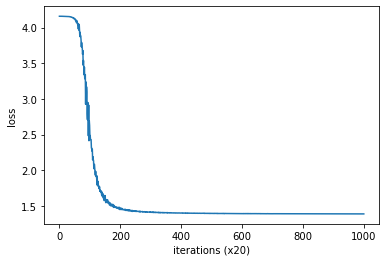

In [6]:
trainer.plot()

In [7]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

now [-2.406494   -1.3359886  -0.01463528  0.17371699 -0.60850954]
processing [ 1.0699152  -0.19422366 -1.734612    0.7705752  -1.8127654 ]
am [ 0.90440714 -0.95872253  0.97527564 -0.16870174  2.338234  ]
studying [ 0.6148318   2.4574852   1.296611   -0.34457648 -0.11082134]
natural [ 2.2434552  -1.220744   -1.5721378   0.12666838  0.9266584 ]
language [-2.3770816   1.466507    0.86329347 -1.074731   -0.08798598]
i [ 0.00642992  0.00231732  0.00313393 -0.01434269  0.02408556]
. [ 0.00239632  0.00177278  0.00878207 -0.01484943 -0.01563045]
